<a href="https://colab.research.google.com/github/ChiNonsoHenry16/ChiNonsoHenry16/blob/main/MLP_for_weight_prediction_for_First_Scientific_Reports_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is code for the paper titled, "Automatic measurement and prediction of Chinese Grown Pigs weight using multilayer perceptron neural networks".
URL: https://www.nature.com/articles/s41598-023-28433-2


## PREDICTIVE MODELLING OF PIG WEIGHTS USING MULTILAYER PERCEPTRON

In [ ]:
# The following libraries are for data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# The libraries below are Pytorch libraries for the linear regression modelling
import torch
from torch.nn import Linear    # linear function
from torch.nn import ReLU      # relu activation function fot transformation
from torch.optim import Adam   # For optimizing the loss function
from torch.nn import MSELoss
import torch.nn.functional as F

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt

# visualization
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-72wynwba
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-72wynwba
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4990 sha256=f5a16925ed2312de433d979d2984b11b38ffa3080d0912c3609b5cffcc05ef3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-opa1hsen/wheels/50/d5/0c/a58eabcbe90646a0801d1ed8011e1e517f6160bb03d22be4e7
Successfully built torchviz


 # Data Importation

**PLEASE NOTE**
* Name your data **dataset**



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.xlsx to dataset.xlsx


In [ ]:
#df_test=pd.read_csv('data.csv',parse_dates=['measure day','birth day'])
import io
data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
data.rename(columns={'male/female':'gender'},inplace=True)

#train_df=pd.read_csv('dataset.csv',parse_dates=['Date of determination','date of birth'])

data.head()

<ipython-input-3-da0ec06ccf60>:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  data = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))


,Serial number,breed,gender,Date of determination,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,date of birth,Weight measurement,Length of pig,The height of a pig
0,1,S21,female,2016-04-22,110,115,107,2015-10-12,113.5,120,0
1,2,S21,female,2016-04-22,105,116,106,2015-10-13,111.4,119,0
2,3,S21,female,2016-04-22,109,120,104,2015-10-11,114.6,125,0
3,4,S21,female,2016-04-22,105,112,100,2015-10-13,111.8,123,0
4,5,S21,female,2016-04-22,107,116,106,2015-10-16,114.2,118,0


## Summary Statistics
The visualizations below shows the distribution of gender and breed of pigs in the dataset.The are 5438 females and  males in the dataset. 8068 of the pigs are of breed S21 and 1912 are S23.

In [ ]:
# Counts of S21 and S23 pigs in the dataset
data['breed'].value_counts()

S21    8068
S23    1912
Name: breed, dtype: int64

In [ ]:
# Counts of male and female pigs in the dataset
data['gender'].value_counts()

female    5438
male      4542
Name: gender, dtype: int64

In [ ]:
# Average weight of female and male pigs
data['Weight measurement'].groupby(data['gender']).mean()

gender
female    108.457613
male      113.149665
Name: Weight measurement, dtype: float64

In [ ]:
# Average weight of S21 and S23 pigs
data['Weight measurement'].groupby(data['breed']).mean()

breed
S21    111.712219
S23    105.870345
Name: Weight measurement, dtype: float64

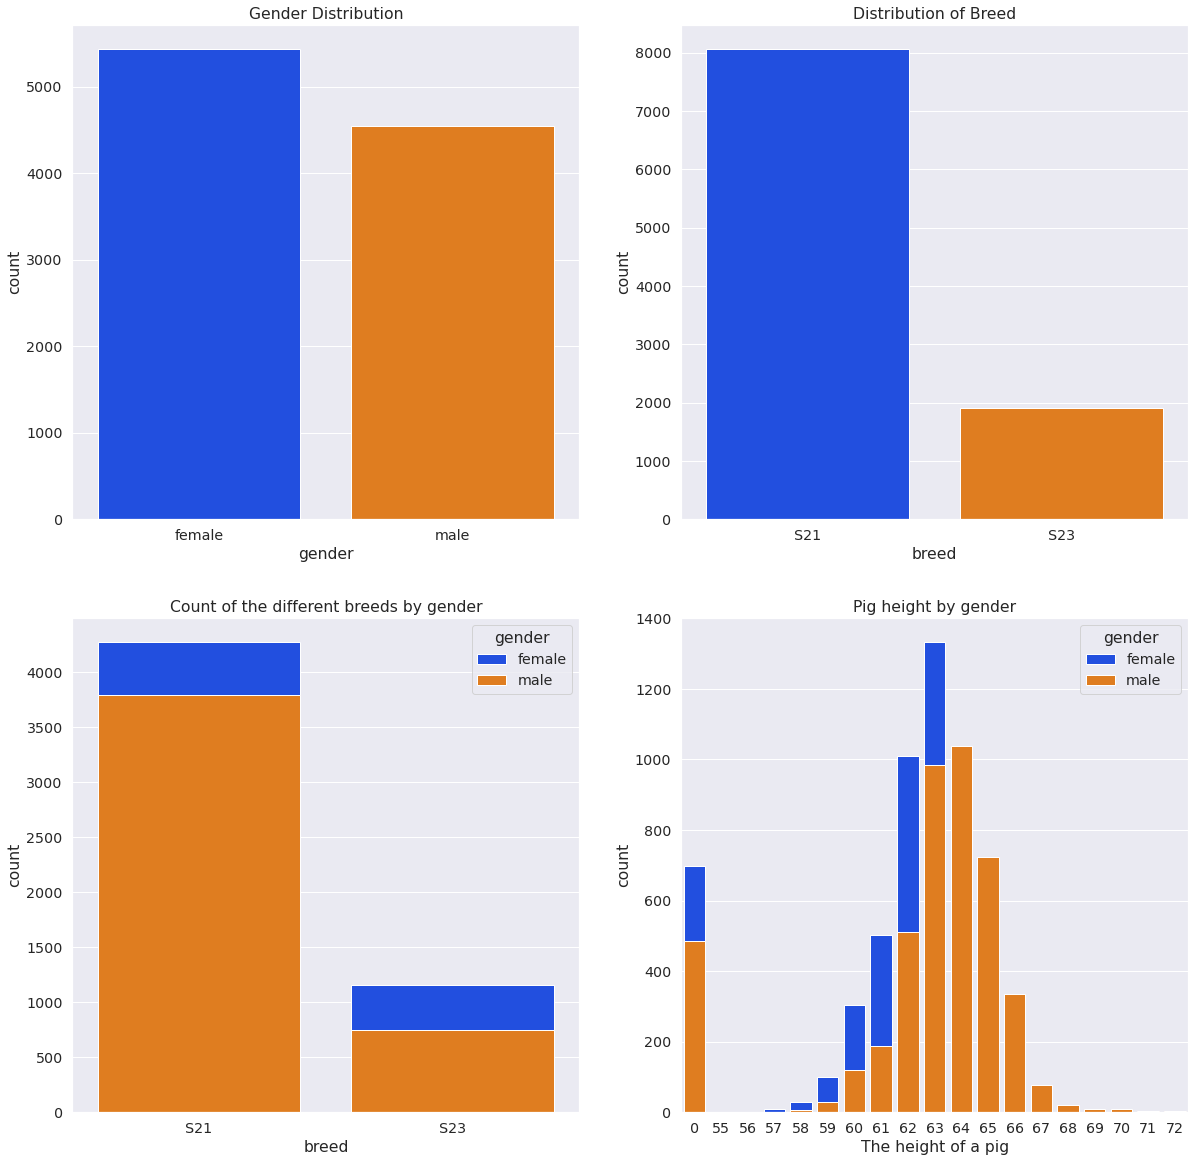

In [ ]:
# Visualization of the features of the pigs
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.countplot(x='breed',data=data, hue='gender',palette=sns.color_palette("bright", 2),dodge=False,
              ax=ax[1][0]).set_title("Count of the different breeds by gender")
sns.countplot(x='The height of a pig', data=data, hue='gender',palette=sns.color_palette("bright", 2),dodge=False,
              ax=ax[1][1]).set_title("Pig height by gender")
sns.countplot(x='gender', data=data,palette=sns.color_palette("bright", 4),dodge=False,
              ax=ax[0][0]).set_title("Gender Distribution")

sns.countplot(x='breed', data=data,palette=sns.color_palette("bright", 2),dodge=False,ax=ax[0][1],
             ).set_title("Distribution of Breed")#ax=ax[1][1]
sns.set(font_scale=1.3)
plt.show()


# Data Cleaning
This included,
* Creation of a new column called **age in days** which was the difference between the date of determination and date of birth
* Conversion of the gender and breed types to numerical variables (OneHot Encoding)
* Imputation of missing values in the **pig height** with the median height

In [ ]:
data['Date of determination']=pd.to_datetime(data['Date of determination'])
data['date of birth']=pd.to_datetime(data['date of birth'])
cleaned_data=pd.concat([data,pd.get_dummies(data['gender'])],axis=1)
cleaned_data=pd.concat([cleaned_data,pd.get_dummies(data['breed'])],axis=1)
cleaned_data['age in days']=(cleaned_data['Date of determination']-cleaned_data['date of birth']).dt.days
cleaned_data.drop(['Serial number','breed','gender','Date of determination','date of birth',],axis=1,inplace=True)

median=cleaned_data[cleaned_data['The height of a pig']!=0]['The height of a pig'].median()
cleaned_data['The height of a pig']=[median if item==0 else item for item in cleaned_data['The height of a pig']]

cleaned_data.head()

,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,Weight measurement,Length of pig,The height of a pig,female,male,S21,S23,age in days
0,110,115,107,113.5,120,63.0,1,0,1,0,193
1,105,116,106,111.4,119,63.0,1,0,1,0,192
2,109,120,104,114.6,125,63.0,1,0,1,0,194
3,105,112,100,111.8,123,63.0,1,0,1,0,192
4,107,116,106,114.2,118,63.0,1,0,1,0,189


# MODEL1: PREDICTION OF WEIGHT USING ALL FEATURES
**Features**<br>
The features or parameters selected for the modelling are,
* Chest circumference of pig
* Abdominal circumference of pigs
* Waist circumference of pig
* Length of pig
* The height of a pig
* Male
* Female
* S21. Type of breed
* S23. Type of breed
* Age in days

**Label**
* Weight measurement
## Splitting dataset into traning and testing set
In this section, 80% of the dataset is used to train the linear regression model and 20% is used for testing or validation.<br>
The individual datasets are then converted into tensors to be utilized by the Pytorch Framework

In [ ]:

# Splitting cleaned_data into training and test sets

X1=cleaned_data.drop('Weight measurement',axis=1)
y=np.array(cleaned_data['Weight measurement'])
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=6)


# Converting numpy arrays to tensors

X_train = torch.from_numpy(X_train.values.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_train = y_train.view(y_train.shape[0], 1)
X_test=torch.from_numpy(X_test.values.astype(np.float32))


# Modelling
This model is a 4 -layered Multilayer Perceptron (MLP) with the input layer, 2nd, 3rd and output layer being linear. <br>
The model utilizes two Relu activation functions in the hidden layers.

In [ ]:
num_samples, num_features = X_train.shape
#input_size = num_features


class MLP(torch.nn.Module):

  def __init__(self, num_features):
    super(MLP, self).__init__()
    self.fc1 = Linear(num_features, 5) # Input layer
    self.fc2 = Linear(5, 4)          # 1st Hidden layer with 5 neurons
    self.fc3 = Linear(4, 4)          # 2nd hidden layer with 4 neurons
    self.fc4 = Linear(4, 1)          # 3rd hidden layer with 4 nerons

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc4(x)              # Output layer with 1 neuron

model_1 = MLP(num_features)



# Training the model


epoch: 10, loss = 36.0622
epoch: 20, loss = 33.0168
epoch: 30, loss = 32.4546
epoch: 40, loss = 31.7306
epoch: 50, loss = 31.3735
epoch: 60, loss = 30.9432
epoch: 70, loss = 30.5258
epoch: 80, loss = 30.1229
epoch: 90, loss = 29.7328
epoch: 100, loss = 29.3526
epoch: 110, loss = 28.9813
epoch: 120, loss = 28.6215
epoch: 130, loss = 28.2735
epoch: 140, loss = 27.9383
epoch: 150, loss = 27.6166
epoch: 160, loss = 27.3087
epoch: 170, loss = 27.0153
epoch: 180, loss = 26.7367
epoch: 190, loss = 26.4732
epoch: 200, loss = 26.2251
epoch: 210, loss = 25.9924
epoch: 220, loss = 25.7751
epoch: 230, loss = 25.5733
epoch: 240, loss = 25.3867
epoch: 250, loss = 25.2150
epoch: 260, loss = 25.0577
epoch: 270, loss = 24.9143
epoch: 280, loss = 24.7840
epoch: 290, loss = 24.6662
epoch: 300, loss = 24.5599


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


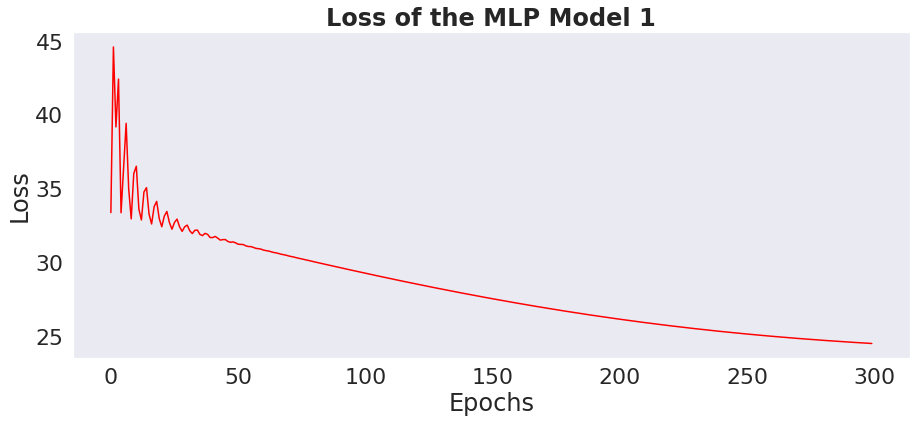

In [ ]:
model1_criterion = MSELoss()                            # Evaluation metric: Mean Squared Error
model1_optimizer = Adam(model_1.parameters(), lr=0.01)    # model1_optimizer Adam

# enumerate epochs
model1_time_step,model1_mse=[],[]
epochs=300
for epoch in range(epochs):                      # Number of Epochs is 300
    # clear the gradients
    model1_optimizer.zero_grad()

    # compute the model output
    model1_prediction = model_1(X_train)

    # calculate loss
    model1_loss = model1_criterion(model1_prediction, y_train)

    model1_loss.backward()

    # update model weights
    model1_optimizer.step()
    model1_mse.append(model1_loss.item())
    if (epoch+1) % 10 == 0:
        # model1_time_step.append(epoch+1)
        # mse.append(loss.item())
        print(f'epoch: {epoch+1}, loss = {model1_loss.item():.4f}')


sns.set_style("dark")
plt.figure(figsize=(15,6))
fig=sns.lineplot(range(epochs),model1_mse,color = 'red')
fig.set(xlabel="Epochs", ylabel = "Loss")
plt.title('Loss of the MLP Model 1',weight='bold')
plt.show(fig)

## Neural Network Architecture

The neurons in green color are the actual parameters/features used in training the data and the single red layer is the output layer. Since the number of features used in the model is 10,the first layer / input layer has 10 neurons. Thus, the first blue colored layer.<br>
There are 5, 4 and 4 neurons in the second, third and fourth layers respectively. The neurons other than the input and out layers are called **Hidden Layers**.<br>
Hence, this network has 3 hidden layers.
<center><img src="architecture.png", width="500",height = "150"></center>

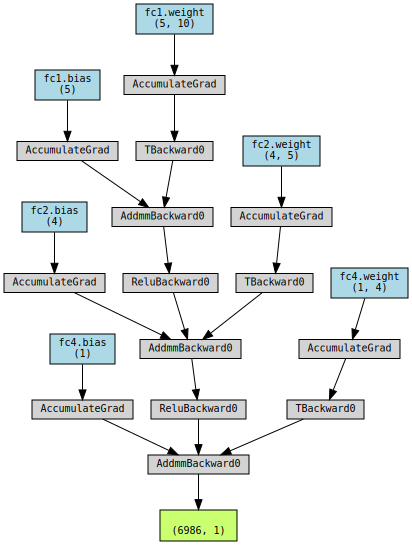

In [ ]:
make_dot(model_1(X_train), params=dict(model_1.named_parameters()))

# Model 1 Evaluation

In [ ]:
# Comparing Actual weights and predicted weights for the test set
model1_predicted = model_1(X_test).detach().numpy()
model1_actual_predicted_weight=pd.DataFrame({'actual':y_test,'predicted':model1_predicted.flatten()})
model1_actual_predicted_weight

,actual,predicted
0,108.0,107.001816
1,105.7,109.442764
2,120.0,108.336082
3,100.2,104.617050
4,123.4,116.184555
...,...,...
2989,106.2,111.169640
2990,118.6,114.994080
2991,105.3,106.388168
2992,105.2,110.580780


## Model_1 Evaluation

In [ ]:
# Model Evaluation using Mean Squared Error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
model1_MSE = mse(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
model1_MAE = mae(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
model1_MAPE = mape(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
print('\n\nMean Squared Error(MSE): {} \n\nRoot Mean Square Error(RMSE): {}'.format(model1_MSE,model1_MSE**0.5))
print('\n\nMean Absolute Error (MAE): {} \n\nMean Absolute Percentage Error(MAPE): {}'.format(model1_MAE,model1_MAPE))



Mean Squared Error(MSE): 34.363726348716575 

Root Mean Square Error(RMSE): 5.862058200727503


Mean Absolute Error (MAE): 4.671770109585626 

Mean Absolute Percentage Error(MAPE): 0.04211473376563829


# Model 1 Prediction

In [ ]:
def predict(row, model):
    # convert row to data
    row = torch.Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    print('Predicted: %.3f' % yhat)

# Make Predictions
row = [106., 110., 103., 116.,  63.,   1.,   0.,   0.,   1., 127.] # The new data sholud be of length 8
predict(row, model_1)

Predicted: 98.662


# MODEL2: Prediction of WEIGHT using a subset of features
The features selected are,
* Chest circumference of pig
* Abdominal circumference of pigs
* Waist circumference of pig
* The height of a pig

**The above features were selected based on correlation analysis of the entire feature set. Chest circumference, Abdominal Circumfence and Waist Circumference have high correlation leading to multicolinearity. Hence, one of them is selected for the regression analysis**

In [ ]:
# Correlation matrix showing the correlation between each pair of features
cleaned_data.corr()

,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,Weight measurement,Length of pig,The height of a pig,female,male,S21,S23,age in days
Chest circumference of pig,1.000000,0.832291,0.857066,0.643406,0.555667,0.443640,-0.206310,0.206310,0.174250,-0.174250,-0.052457
Abdominal circumference of pigs,0.832291,1.000000,0.827619,0.615184,0.560713,0.447656,-0.200997,0.200997,0.211088,-0.211088,-0.091251
Waist circumference of pig,0.857066,0.827619,1.000000,0.605605,0.529327,0.411785,-0.194867,0.194867,0.201123,-0.201123,-0.079258
Weight measurement,0.643406,0.615184,0.605605,1.000000,0.692095,0.433187,-0.331329,0.331329,0.326012,-0.326012,0.079378
Length of pig,0.555667,0.560713,0.529327,0.692095,1.000000,0.591246,-0.297071,0.297071,0.233412,-0.233412,-0.029379
The height of a pig,0.443640,0.447656,0.411785,0.433187,0.591246,1.000000,-0.257893,0.257893,0.148746,-0.148746,-0.034977
female,-0.206310,-0.200997,-0.194867,-0.331329,-0.297071,-0.257893,1.000000,-1.000000,-0.060930,0.060930,0.201624
male,0.206310,0.200997,0.194867,0.331329,0.297071,0.257893,-1.000000,1.000000,0.060930,-0.060930,-0.201624
S21,0.174250,0.211088,0.201123,0.326012,0.233412,0.148746,-0.060930,0.060930,1.000000,-1.000000,-0.321935
S23,-0.174250,-0.211088,-0.201123,-0.326012,-0.233412,-0.148746,0.060930,-0.060930,-1.000000,1.000000,0.321935


In [ ]:
# Selection of features for prediction
selected_features=cleaned_data[['Length of pig','The height of a pig','Chest circumference of pig','age in days']]
labels=y

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(selected_features, labels, test_size=0.3, random_state=10)


# Converting numpy arrays to tensors

X_train_selected = torch.from_numpy(X_train_selected.values.astype(np.float32))
y_train_selected = torch.from_numpy(y_train_selected.astype(np.float32))
y_train_selected = y_train_selected.view(y_train_selected.shape[0], 1)
X_test_selected=torch.from_numpy(X_test_selected.values.astype(np.float32))


## MLP_2 Construction

In [ ]:
n_samples_selected, n_features_selected = X_train_selected.shape
#input_size = n_features


class MLP_2(torch.nn.Module):

  def __init__(self, n_features):
    super(MLP_2, self).__init__()
    self.fc1 = Linear(n_features_selected, 10) # Input layer
    self.fc2 = Linear(10, 4)          # 1st Hidden layer with 5 neurons
    self.fc3 = Linear(4, 4)          # 2nd hidden layer with 4 neurons
    self.fc4 = Linear(4, 1)          # 3rd hidden layer with 4 nerons
        # 3rd hidden layer with 4 nerons

  def forward(self, x1):
    x1 = F.relu(self.fc1(x1))
    x1 = F.relu(self.fc2(x1))
    return self.fc4(x1)              # Output layer with 1 neuron

model_2 = MLP_2(n_features_selected)


epoch: 10, loss = 5475.4814
epoch: 20, loss = 308.2759
epoch: 30, loss = 97.4297
epoch: 40, loss = 251.1918
epoch: 50, loss = 70.7850
epoch: 60, loss = 45.8411
epoch: 70, loss = 51.9107
epoch: 80, loss = 48.5429
epoch: 90, loss = 45.6863
epoch: 100, loss = 44.8712
epoch: 110, loss = 44.7234
epoch: 120, loss = 44.6433
epoch: 130, loss = 44.5483
epoch: 140, loss = 44.4464
epoch: 150, loss = 44.3426
epoch: 160, loss = 44.2372
epoch: 170, loss = 44.1297
epoch: 180, loss = 44.0197
epoch: 190, loss = 43.9071
epoch: 200, loss = 43.7919
epoch: 210, loss = 43.6742
epoch: 220, loss = 43.5541
epoch: 230, loss = 43.4318
epoch: 240, loss = 43.3072
epoch: 250, loss = 43.1805
epoch: 260, loss = 43.0517
epoch: 270, loss = 42.9209
epoch: 280, loss = 42.7883
epoch: 290, loss = 42.6538
epoch: 300, loss = 42.5175


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


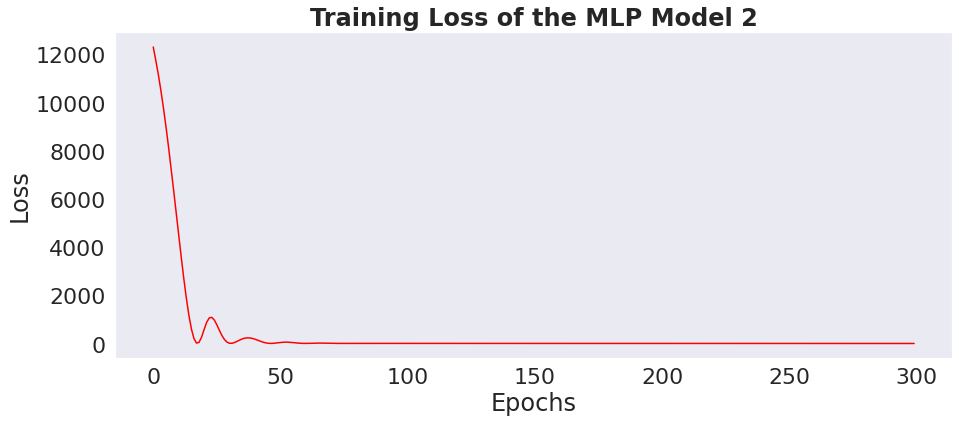

In [ ]:
model2_criterion = MSELoss()                         # Evaluation metric: Mean Squared Error
model2_optimizer = Adam(model_2.parameters(), lr=0.01) # Optimizer Adam
# enumerate epochs
model2_time,model2_mse=[],[]
epochs=300
for epoch in range(epochs):                      # Number of Epochs is 300
    # clear the gradients
    model2_optimizer.zero_grad()
    # compute the model output
    yhat_selected = model_2(X_train_selected)
    # calculate loss
    model2_loss = model2_criterion(yhat_selected, y_train_selected)
    # credit assignment
    model2_loss.backward()
    # update model weights
    model2_optimizer.step()
    model2_mse.append(model2_loss.item())
    if (epoch+1) % 10 == 0:
#         model2_time.append(epoch+1)
#         model2_mse.append(loss.item())
        print(f'epoch: {epoch+1}, loss = {model2_loss.item():.4f}')

# Plotting the loss function
sns.set_style("dark")
plt.figure(figsize=(15,6))
fig1=sns.lineplot(range(epochs),model2_mse,color = 'red')#range(epochs)
fig1.set(xlabel="Epochs", ylabel = "Loss")
plt.title('Training Loss of the MLP Model 2',weight='bold')
plt.show(fig1)

## Evaluation of Model 2

In [ ]:
# Comparing Actual weights and predicted weights for the test set
model2_predicted = model_2(X_test_selected).detach().numpy()
model2_actual_predicted_weight=pd.DataFrame({'actual':y_test_selected,'predicted':model2_predicted.flatten()})
model2_actual_predicted_weight

,actual,predicted
0,106.5,109.715652
1,117.6,111.927750
2,116.2,108.636955
3,110.0,106.142670
4,107.4,112.996948
...,...,...
2989,124.3,112.524933
2990,109.6,109.552719
2991,103.5,111.291649
2992,101.3,107.530701


## Model_2 Evaluation

In [ ]:
model2_MSE = mse(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
model2_MAE = mae(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
model2_MAPE = mape(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
print('\n\nMean Squared Error(MSE): {} \n\nRoot Mean Square Error(RMSE): {}'.format(model2_MSE,model2_MSE**0.5))
print('\n\nMean Absolute Error (MAE): {} \n\nMean Absolute Percentage Error(MAPE): {}'.format(model2_MAE,model2_MAPE))



Mean Squared Error(MSE): 41.88383709796863 

Root Mean Square Error(RMSE): 6.471772330511065


Mean Absolute Error (MAE): 5.101992627528006 

Mean Absolute Percentage Error(MAPE): 0.045987059722127945


## Using Model 2 for prediction

In [ ]:
def predict(data, model):
    # convert row to data
    new_data = torch.Tensor([data])
    # make prediction
    yhat = model(new_data)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    print('Predicted: %.3f' % yhat)

# Make Predictions
data = [117.,  59., 103., 188.] # The new data sholud be of length 4
predict(data, model_2)

Predicted: 113.092


# Comparative Analysis
The evaluation metrics used in assessing the two models are,
* **Mean Squared Error (MSE)**.
$$MSE = \frac{1}{N}\sum_{i=1}^{N} (Actual_{i}-Predicted_{i})^2$$


* **The Root Mean Squared Error (RMSE)**.
$$RMSE = \sqrt{ \frac{1}{N}\sum_{i=1}^{N} (Actual_{i}-Predicted_{i})^2}$$


* **Mean Absolute Error (MAE)**.
$$MAE = \frac{1}{N}\sum_{i=1}^{N} |Actual_{i}-Predicted_{i}|$$


* **Mean Absolute Percentage Error (MAPE)**.
$$MAPE = \frac{1}{N}\sum_{i=1}^{N} |\frac{Actual_{i}-Predicted_{i}}{Actual_{i}}|$$


A shown from the table below, Model1 has the least of the errors for all the evaluation metrics. Thus the errors incurred by the Model1 for the MSE, RMSE, MAE and the MAPE is the least among the two models.

Since Model1 has the least error, it is the better model for predicting the weight of the pigs.
### NOTE
Model1 uses all the features in the dataset in the modelling process.

In [ ]:
compare_model1_model2 = pd.DataFrame({ 'Metrics':['MSE','RMSE','MAE','MAPE'],
                          'Model_1':[model1_MSE,model1_MSE**0.5,model1_MAE,model1_MAPE],
                         'Model_2':[model2_MSE,model2_MSE**0.5,model2_MAE,model2_MAPE]})
compare_model1_model2

,Metrics,Model_1,Model_2
0,MSE,34.363726,41.883837
1,RMSE,5.862058,6.471772
2,MAE,4.671770,5.101993
3,MAPE,0.042115,0.045987


# Miscellaneous (Showing all predictions for both model 1 and model 2)

## All Predictions for Model 1

In [ ]:
# Model1 Predictions

pd.set_option("max_rows", None)
model1_actual_predicted_weight

,actual,predicted
0,108.0,107.693680
1,105.7,109.307114
2,120.0,110.340210
3,100.2,105.834557
4,123.4,114.039131
5,101.4,111.266830
6,109.7,110.661049
7,110.7,113.030876
8,118.3,115.339088
9,101.7,108.638611


In [ ]:
# Model 2 Predictions
model2_actual_predicted_weight

,actual,predicted
0,106.50,109.715652
1,117.60,111.927750
2,116.20,108.636955
3,110.00,106.142670
4,107.40,112.996948
5,124.80,112.686897
6,115.70,108.528152
7,113.70,108.303795
8,125.00,113.463715
9,114.30,108.092667
